<a href="https://colab.research.google.com/github/wylhtydtm/Nematode-project/blob/master/light_cnn_worm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import tables
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time
import copy

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

In [ ]:
def shift_and_normalize(data):  #Preprocessing step 
    data_m = data.view(np.ma.MaskedArray)
    data_m.mask = data==0
    if data.ndim == 3:
        sub_d = np.percentile(data, 95, axis=(1,2)) #let's use the 95th as the value of the background
        data_m -= sub_d[:, None, None]
    else:
        sub_d = np.percentile(data, 95)
        data_m -= sub_d
        
    data /= 255
    return data

In [ ]:
def img_rescale(img, for_pillow=False):
    """
    Rescale the image between 0 and 1, make it 3D if it was just 2D.
    Unlike prep_for_pytorch, no need to make it 4d (batches) because
    the images will be loaded through the dataloader, and that will already
    create the 4d batches.
    In tierpsy, I manually make a N_images x channels x width x height batches,
    and the input to prep_for_pytorch is n_images x w x h (because grayscale)
    While here the ndim==3 refers to channels...
    If you don't use the dataloader, you'll still need to add one dimension
    in the appropriate place"""
    assert img.ndim==2, 'img_rescale only works with 2d array for now'
    img = img - img.min()
    img = img / img.max()
    if for_pillow:
        img *= 255
        img = img.astype(np.uint8)
    else:
        img = img.astype(np.float32)[None, :, :] # c,w,h
    return img

In [ ]:
class new_dataset(Dataset):

    def __init__(self, hdf5_filename, which_set='train', transform=None):

        self.fname = hdf5_filename
        self.set_name = which_set
        # get labels info
        with tables.File(self.fname, 'r') as fid:
            tmp = pd.DataFrame.from_records(
                fid.get_node('/'+self.set_name)['sample_data'].read())
        self.label_info = tmp[['img_row_id', 'is_worm', 'is_avelinos']]
        # size in hdf5 file is 160x160 (in theory), but we train on 80x80
        self.roi_size = 80  # size we want to train on
        with tables.File(self.fname, 'r') as fid:
            dataset_size = fid.get_node('/train/mask').shape[1]
        pad = (dataset_size - self.roi_size)/2
        self.dd = [pad, dataset_size-pad]
        # any transform?
        self.transform = transform

    def __len__(self):
        return len(self.label_info)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        # I could just use index because img_row_id is the same as the index of
        # label_info, but just in case we ever want to shuffle...
        label_info = self.label_info.iloc[index]
        img_row_id = label_info['img_row_id']
        # read images from disk
        with tables.File(self.fname, 'r') as fid:
            roi_data = fid.get_node(
                '/' + self.set_name + '/mask')[img_row_id,
                                               self.dd[0]:self.dd[1],
                                               self.dd[0]:self.dd[1]].copy()

        # shift_and_normalize wants a float, and pytorch a single, use single
        img = roi_data.astype(np.float32)
        img = shift_and_normalize(img)

        # as of now, the model works even without PIL
        # but transform only works with pil, so:
        if self.transform:  # if any transforms were given to initialiser
            img = img_rescale(img, for_pillow=True)
            img = Image.fromarray(img)
            #img = img.convert(mode='RGB')
            img = self.transform(img)
        else:
            img = img_rescale(img, for_pillow=False)

        # read labels too
        labels = label_info['is_worm']
        labels = np.array(labels, dtype=np.float32).reshape(-1, 1)
        labels = torch.from_numpy(labels)
        # read whether it comes from the old Phenix dataset
        #is_hydra = ~label_info['is_avelinos']
        #of is_hydra = np.array(is_hydra, dtype=np.float32).reshape(-1, 1)
        #is_hydra = torch.from_numpy(is_hydra)

        return img, labels # is_hydra

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
hd = Path('/content/drive/My Drive')
fname = hd / 'Hydra_Phenix_dataset.hdf5'


# parameters
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128

    # define transforms
    # do we need vertical/hor flip?
training_transform = transforms.Compose([transforms.RandomVerticalFlip(p=0.4),
                                         transforms.RandomHorizontalFlip(p=0.4),
                                         transforms.ColorJitter(contrast=0.2, hue=0.2),
                                         transforms.ToTensor()])

validation_transform = transforms.Compose([transforms.RandomVerticalFlip(p=0.4),
                                           transforms.RandomHorizontalFlip(p=0.4),
                                           transforms.ColorJitter(contrast=0.2, hue=0.2),
                                           transforms.ToTensor()])
    
test_transform = transforms.ToTensor()

    # create datasets
train_data = new_dataset(fname, which_set='train',transform=training_transform)
val_data = new_dataset(fname, which_set='val',transform=validation_transform)
    
test_data = new_dataset(fname, which_set='test',transform=test_transform)

    # create dataloaders
    # num_workers=4 crashes in my spyder but works on pure python
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, num_workers=4)
test_loader=DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=4) 

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(), 
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(), 
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)) 
  
        self.drop_out = nn.Dropout2d(0.5)
        self.fc_layers =nn.Sequential(nn.Linear(12800, 2))# define fully connected layer
    
    def forward(self, x):
        x = self.conv_layers(x) # pass input through conv layers
        x = self.drop_out(x)  
        x = x.view(x.shape[0], -1) 
        x = self.fc_layers(x)# pass  through fully connected layer
        return x 

learning_rate = 0.0001
epochs = 100

cnn = ConvNet().to(device) # to instantiate model
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr= learning_rate)

In [ ]:
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}
dataset_sizes = {'train':len(train_loader.dataset), 'validation':len(val_loader.dataset)}

In [ ]:
# Checking whether the input image has the right channel
img = train_data[0][0]
img =img.unsqueeze(0)
print(img.size())

torch.Size([1, 1, 80, 80])


In [ ]:
classes = {0: 'non_worm', 1: 'worm'}

images, labels = next(iter(train_loader)) 
out = torchvision.utils.make_grid(images,nrow=5)
def imshow(inp, title=None):
    """Imshow for Tensor. transpose; to get height and width from tensor. 
    In Pytorch, images are presented as [channels, height, width]"""
    inp = inp.numpy().transpose((1, 2, 0))  
    plt.imshow(inp)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.02, hspace=0)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

imshow(out, title=([classes[x.item()] for x in labels]))

In [1]:
def train_model(model, criterion, optimiser, epochs, verbose= True, tag ='Loss/Train'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    Liveloss= PlotLosses()
    #Iterate through epochs
    for epoch in range(epochs):
        logs = {}
        print('Epoch{}/{}'.format(epoch, epochs-1))
        print('-' * 15)
  
        #Each epoch has a training and validation phase        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
              
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for index, (inputs, labels) in enumerate (dataloaders[phase]):
                inputs,labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1) # flatten
                labels = labels.long()
                prediction = model(inputs) 
                prediction = prediction.view(labels.size(0), -1)  #flatten
                loss = criterion(prediction, labels) #calculate the loss between predicted and ground truth
                optimiser.zero_grad() # zero the paratmeter gradients
                  
                if phase == 'train':
                    if verbose: print('Epoch:', epoch, '\tBatch:', index, '\tLoss', loss.item())
                    loss.backward()  
                    optimiser.step() # backward + optimize only if in training phase

                _, pred = torch.max(prediction, dim= 1)                  
                running_loss += loss.detach() * inputs.size(0) 
                running_corrects += torch.sum(pred == labels.data)

             # calculate average losses fo the entire epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
                
            logs[prefix + ' loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
                    
            #Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

        Liveloss.update(logs)
        Liveloss.send()

    time_elapse = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapse // 60, time_elapse % 60))
    print('Best Val Acc: {}'.format(best_acc)) 
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
cnn = train_model(cnn, criterion, optimiser, epochs)


In [ ]:
PATH = 'drive/My Drive/cnn_model_nobatch_nodropout.pth'
torch.save(cnn.state_dict(), PATH)

In [ ]:
cnn = ConvNet().to(device)
device = torch.device('cpu')
#cnn.load_state_dict(torch.load('drive/My Drive/model_2.pth',map_location=device))
cnn.load_state_dict(torch.load('drive/My Drive/cnn_model_nobatch_nodropout.pth',map_location=device))

<All keys matched successfully>

In [ ]:
cnn.eval()

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), 

In [ ]:
if torch.cuda.is_available():
    cnn.cuda()
from torchsummary import summary
summary(cnn,(1,80,80))

In [ ]:
def measure_performance(predictions, labels):
    # go logical for ease
    predictions = predictions.astype(bool)
    labels = labels.astype(bool)
    # true positives
    tp = np.logical_and(predictions, labels).sum()
    # true negatives
    tn = np.logical_and(~predictions, ~labels).sum()
    # false positives
    fp = np.logical_and(predictions, ~labels).sum()
    # false negatives
    fn = np.logical_and(~predictions, labels).sum()
    # accuracy
    accuracy = (tp + tn) / len(predictions)
    print(f"accuracy = {accuracy}")
    # precision
    precision = tp / (tp + fp)
    print(f"precision = {precision}")
    # recall
    recall = tp / (tp + fn)
    print(f"recall = {recall}")
    # F1
    f1 = 2*tp / (2*tp + fp + fn)
    print(f"F1 score = {f1}")
    return

In [ ]:
labels = []
predictions = []
# Do not perform backpagtion during inference, to reduce memory usage
with torch.no_grad():
  for images, labs in test_loader:
    images = images.to(device)
    preds = cnn(images)
    preds = torch.argmax(preds, axis=1)
    predictions.append(preds)
    labels.append(labs)

  predictions = np.concatenate(predictions, axis=0)
  labels = np.concatenate(labels, axis=0).squeeze()

print("\nPerformance ")
measure_performance(predictions, labels)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#Binary classification
target_names = ['non_worm', 'worm']
print(classification_report(labels, predictions, target_names=target_names))

In [ ]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [ ]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 8
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            #npimg = (npimg - np.mean(npimg)) / np.std(npimg) 
            #npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow( npimg, cmap='gray')
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.conv_layers[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.conv_layers[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

In [ ]:
#visualize weights for alexnet - first conv layer
# dark sauqres indicate small or inbitory weights and the light squares represent large or excitory weight.
# We can see the filters in the first convlutional layer detect a gradident from light in the top left to dark in the bottom right
# challenging to see any detail still

plot_weights(cnn, 0, single_channel = True)

In [ ]:
plot_weights(cnn, 2, single_channel = True)

In [ ]:
labels = []
predictions = []
is_hydras = []
with torch.no_grad():
  for images, labs, is_h in val_loader:
    images = images.to(device)
    preds = cnn (images)
    preds = torch.argmax(preds, axis=1)
    predictions.append(preds)
    labels.append(labs)
    is_hydras.append(is_h)
    # concatenate accumulators into np arrays for ease of use
predictions = np.concatenate(predictions, axis=0)
labels = np.concatenate(labels, axis=0).squeeze()
is_hydras = np.concatenate(is_hydras, axis=0).squeeze().astype(bool)

    # measure performance
print("\nPerformance on Hydra data")
measure_performance(predictions[is_hydras], labels[is_hydras])
print("\nPerformance on Phenix data")
measure_performance(predictions[~is_hydras], labels[~is_hydras])

In [ ]:
#Four-class classification
target_names = ['non_worm', 'worm']
print("\nPerformance on Hydra data")
print(classification_report(labels[is_hydras], predictions[is_hydras], target_names=target_names))


In [ ]:
#Four-class classification
target_names = ['non_worm', 'worm']
print("\nPerformance on Phenix data")
print(classification_report(labels[~is_hydras], predictions[~is_hydras], target_names=target_names))


In [ ]:
conv_layers=[]
model_weights=[]
model_children = list(cnn.children())
print(model_children) 

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor. transpose; to get height and width from tensor. 
    In Pytorch, images are presented as [channels, height, width]"""
    inp = inp.numpy().transpose((1, 2, 0)) 
    inp = inp.squeeze() 
    plt.imshow(inp, cmap='gray')
    plt.axis("off")
    plt.subplots_adjust(wspace=0.02, hspace=0)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

imshow(img)

In [ ]:
counter = 0
for j in range(22):
      if type(model_children[0][j]) == nn.Conv2d:
          counter +=1
          model_weights.append(model_children[0][j].weight)
          conv_layers.append(model_children[0][j])
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 8


In [ ]:
model_children[0][0].weight.shape

torch.Size([16, 1, 3, 3])

In [ ]:
# Pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
  #pass the reulst form the last layer to the next layer
  results.append(conv_layers[i](results[-1]))

# Make a copy of the resuts, not manipulating the original results
outputs= results

torch.Size([16, 80, 80])


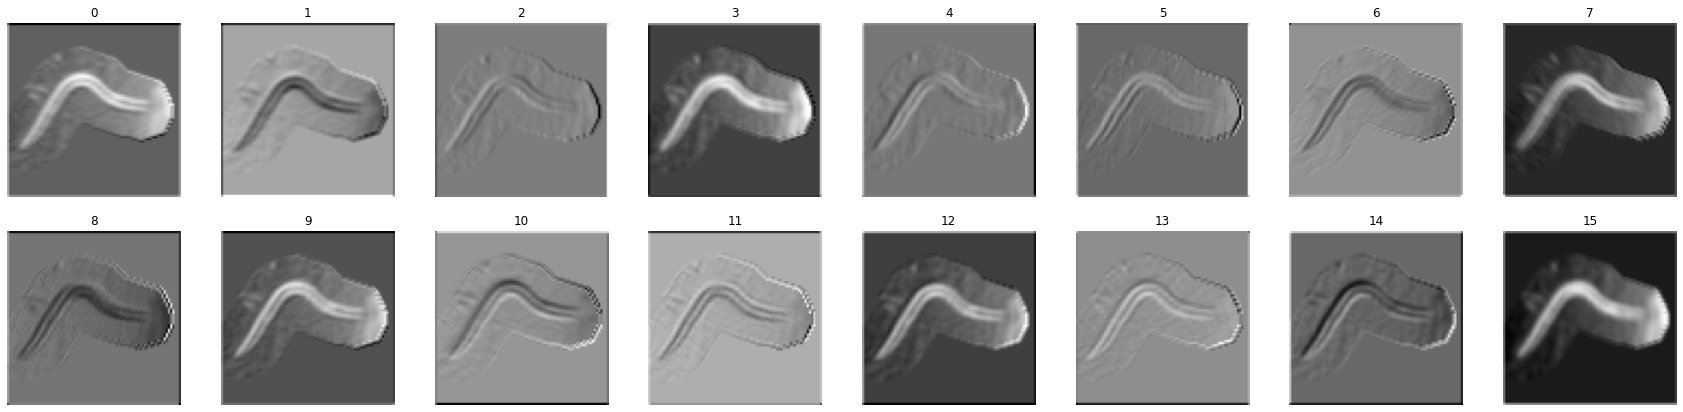

torch.Size([32, 80, 80])


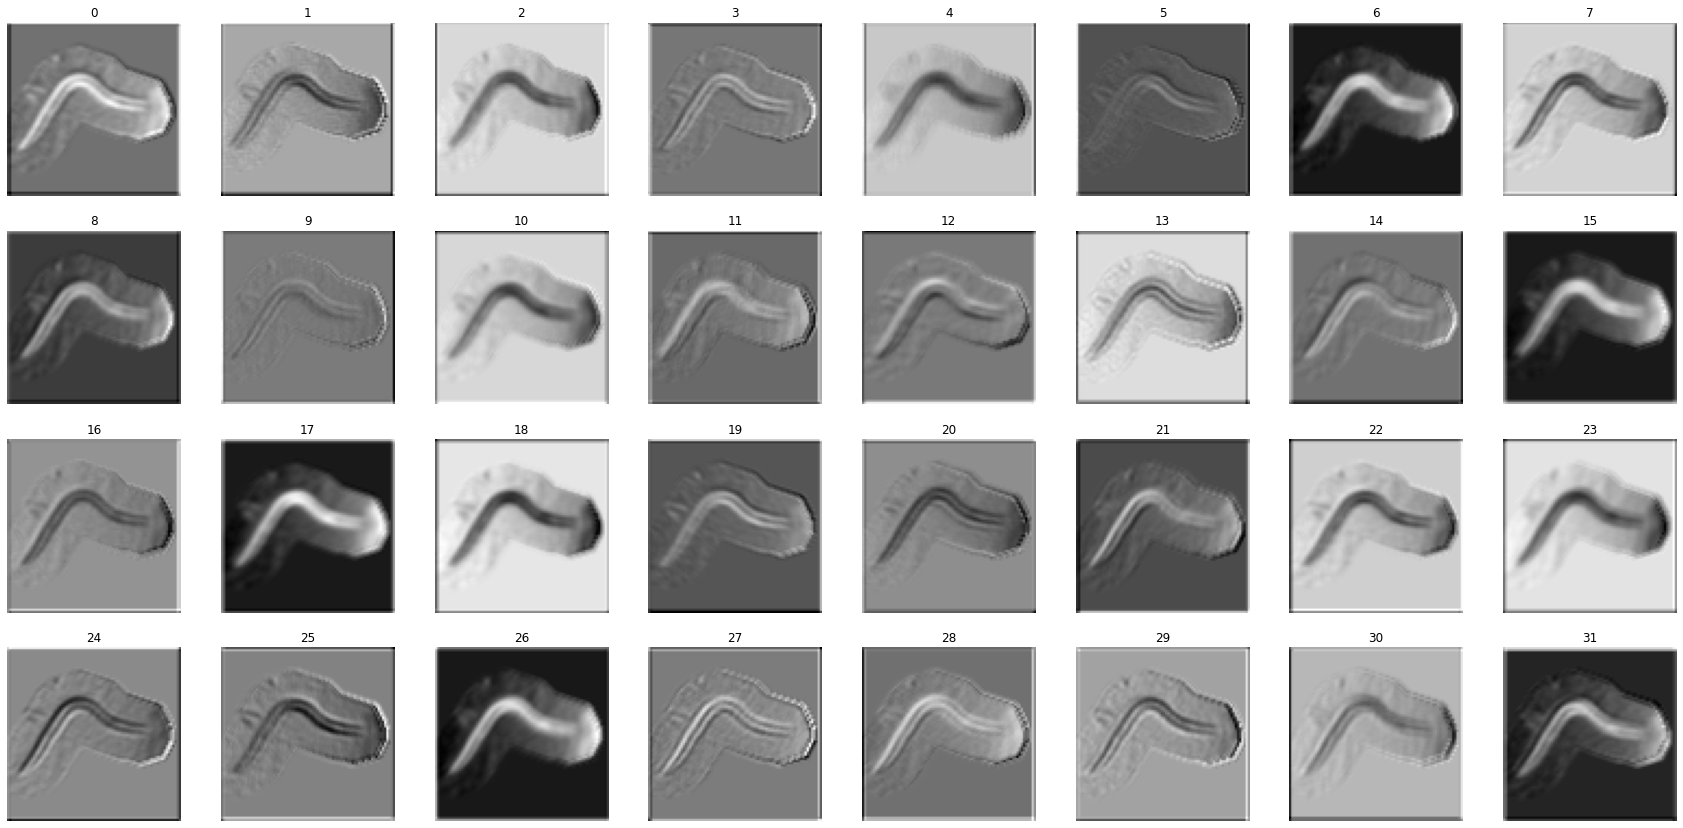

torch.Size([64, 80, 80])


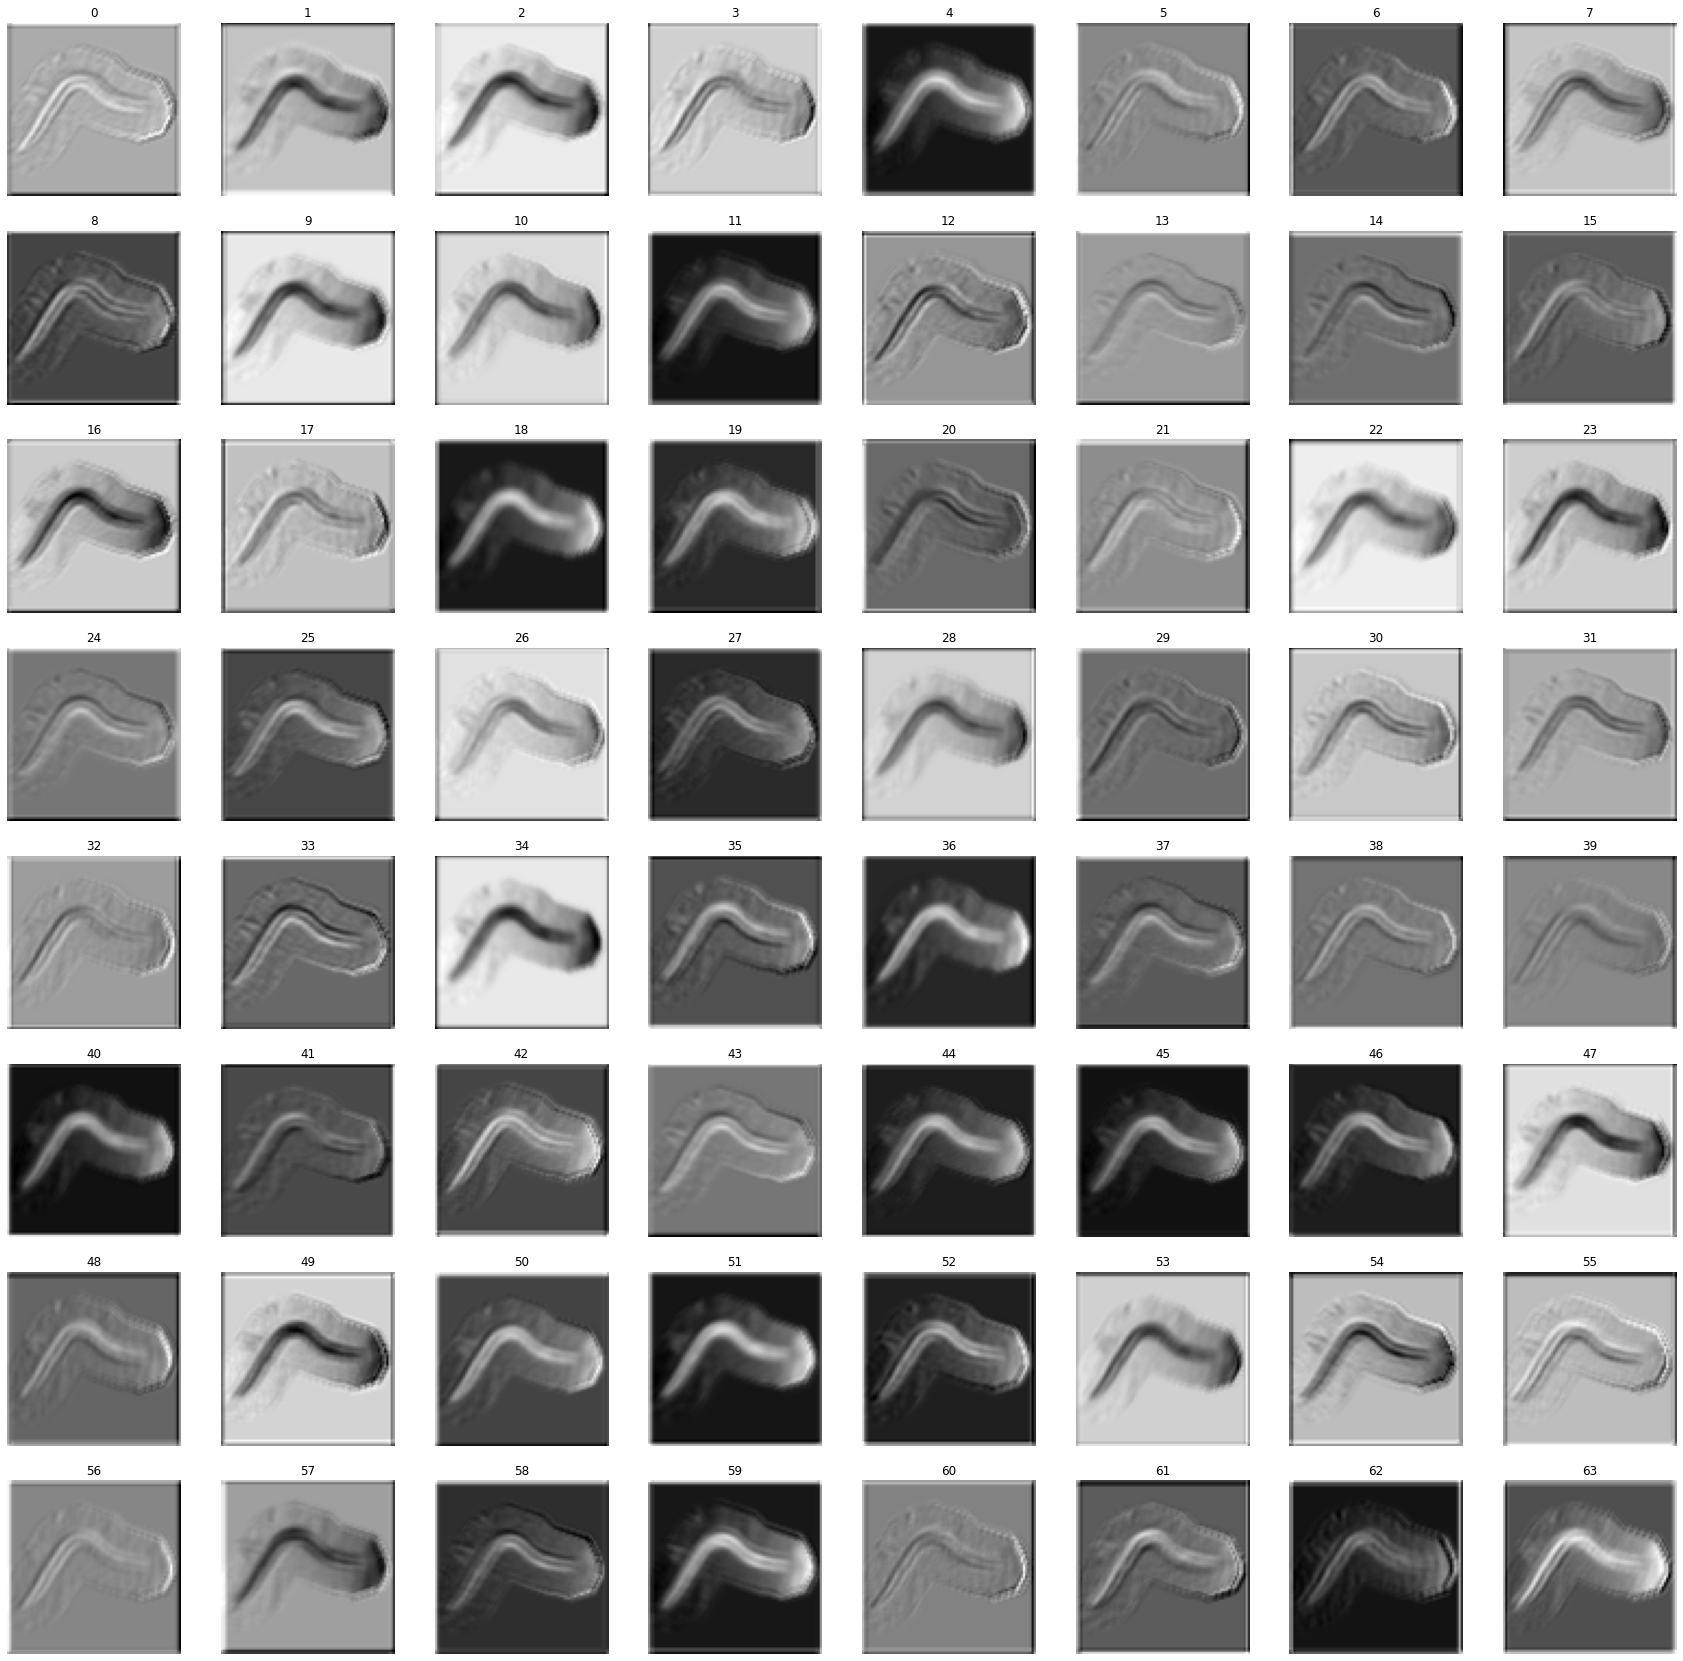

torch.Size([64, 80, 80])


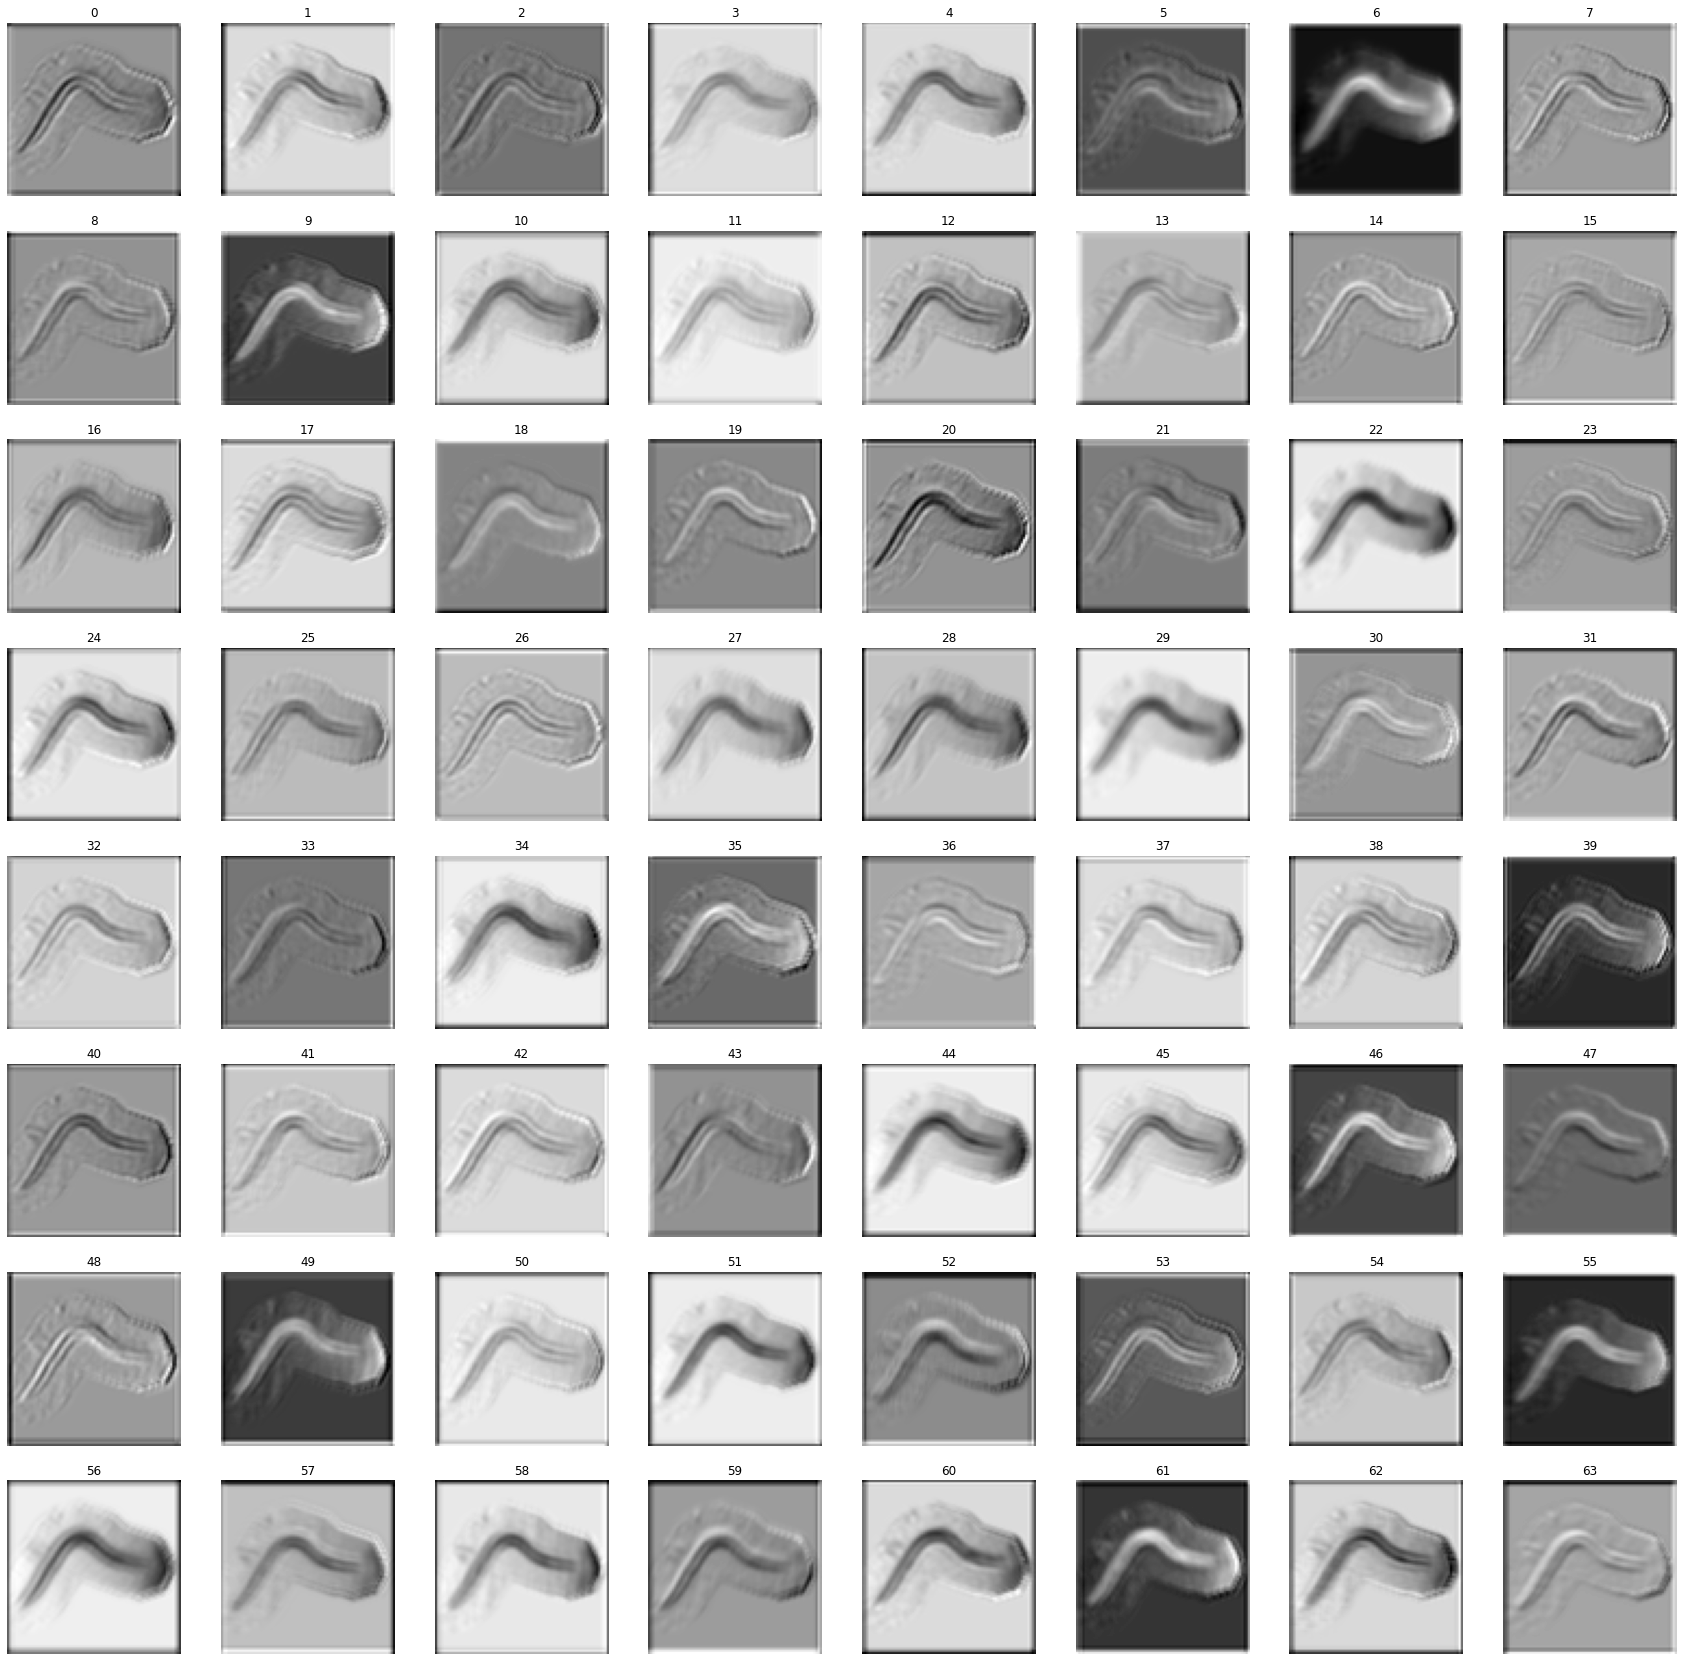

torch.Size([128, 80, 80])


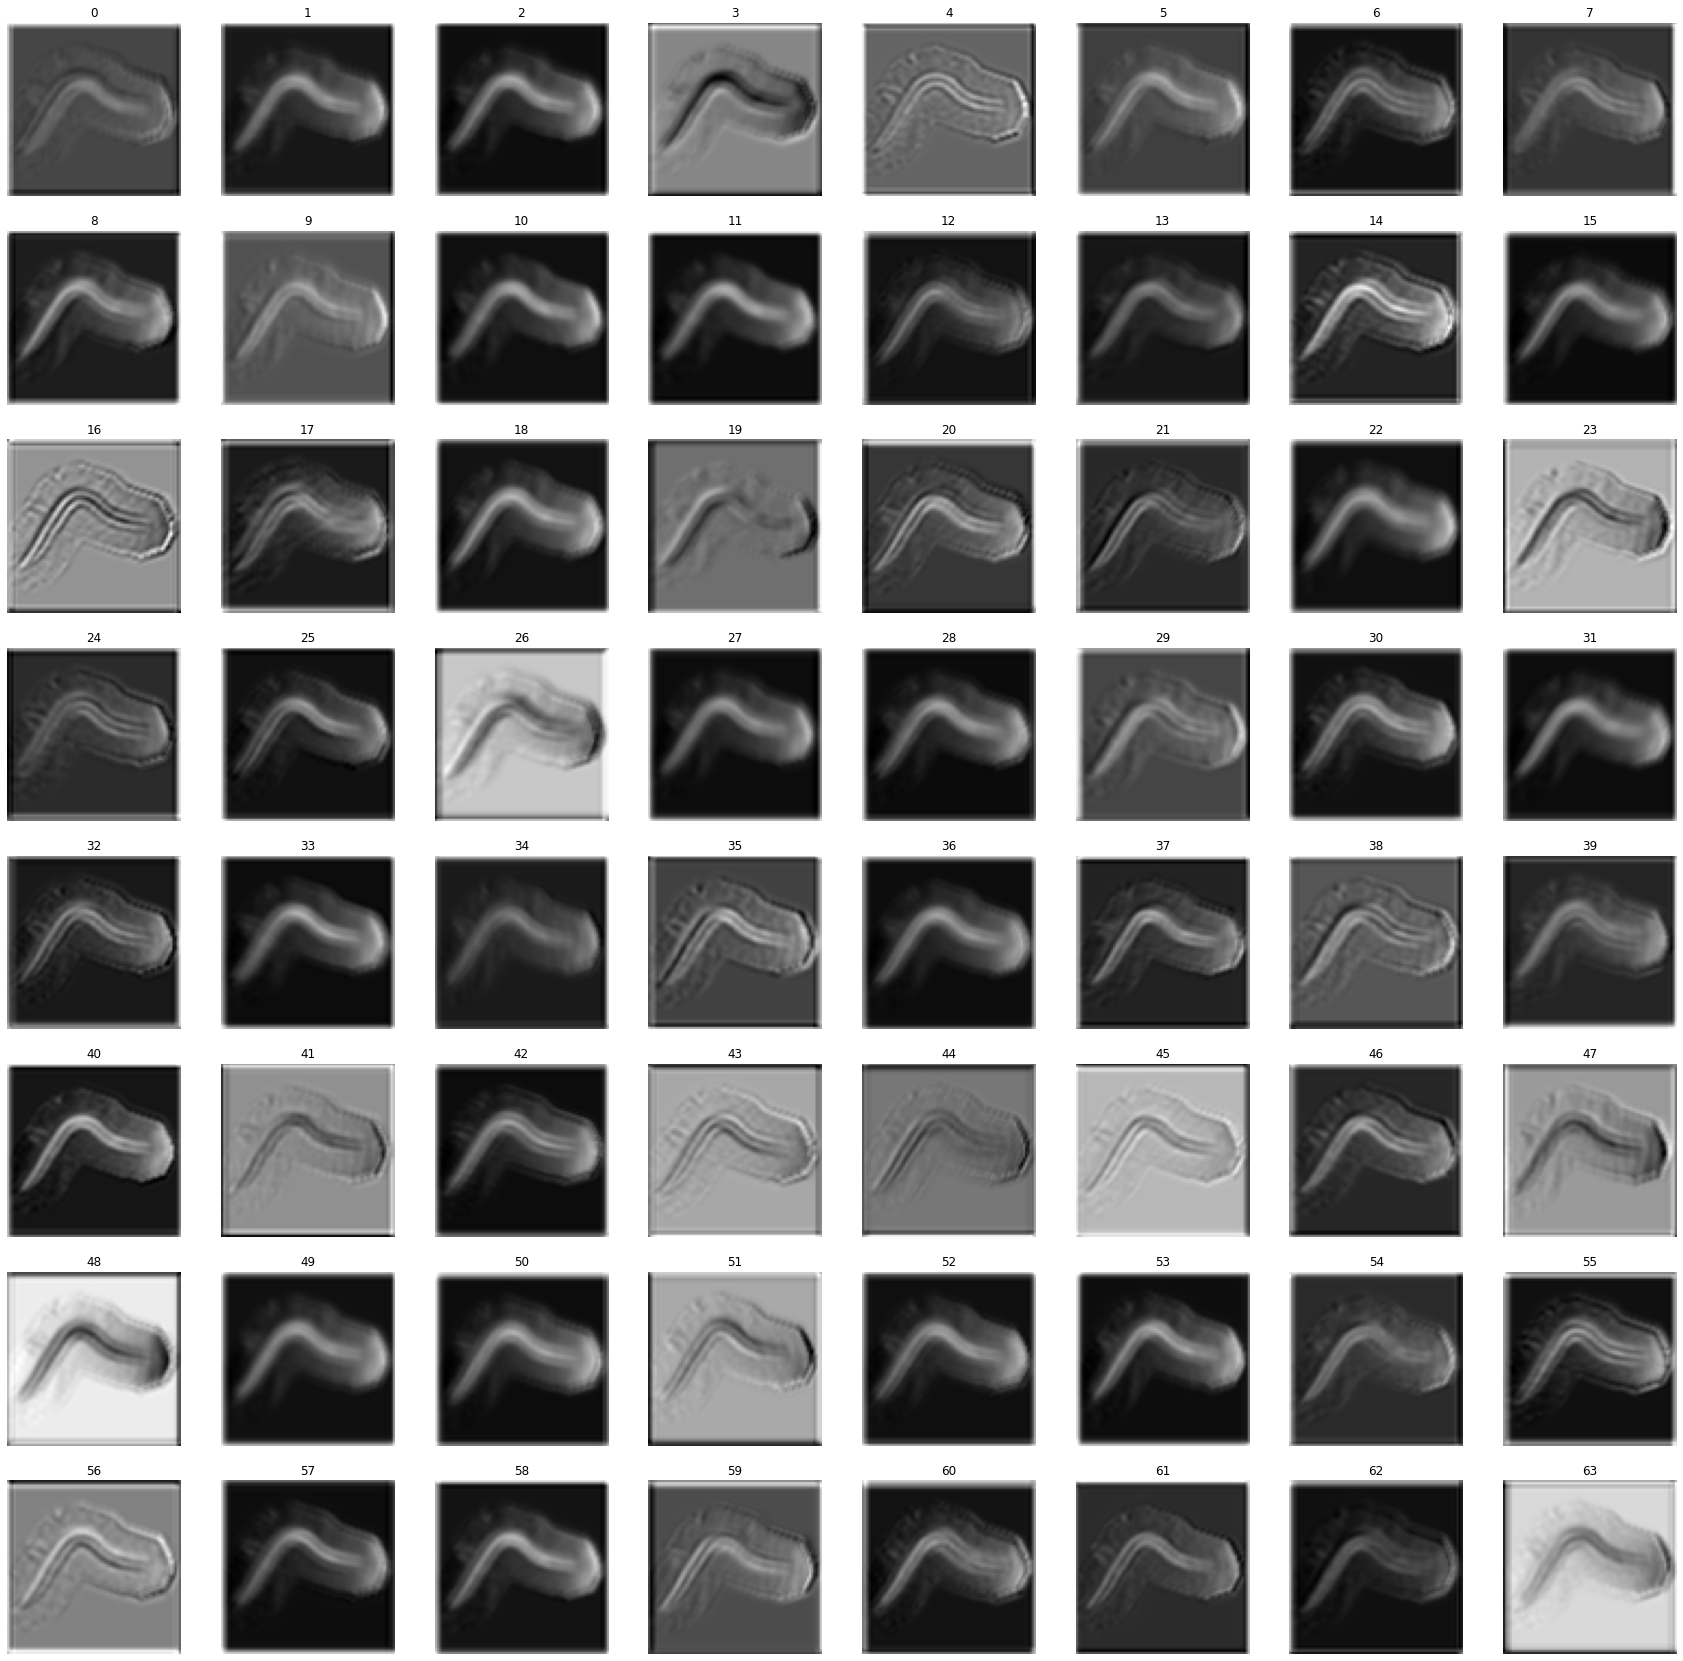

torch.Size([128, 80, 80])


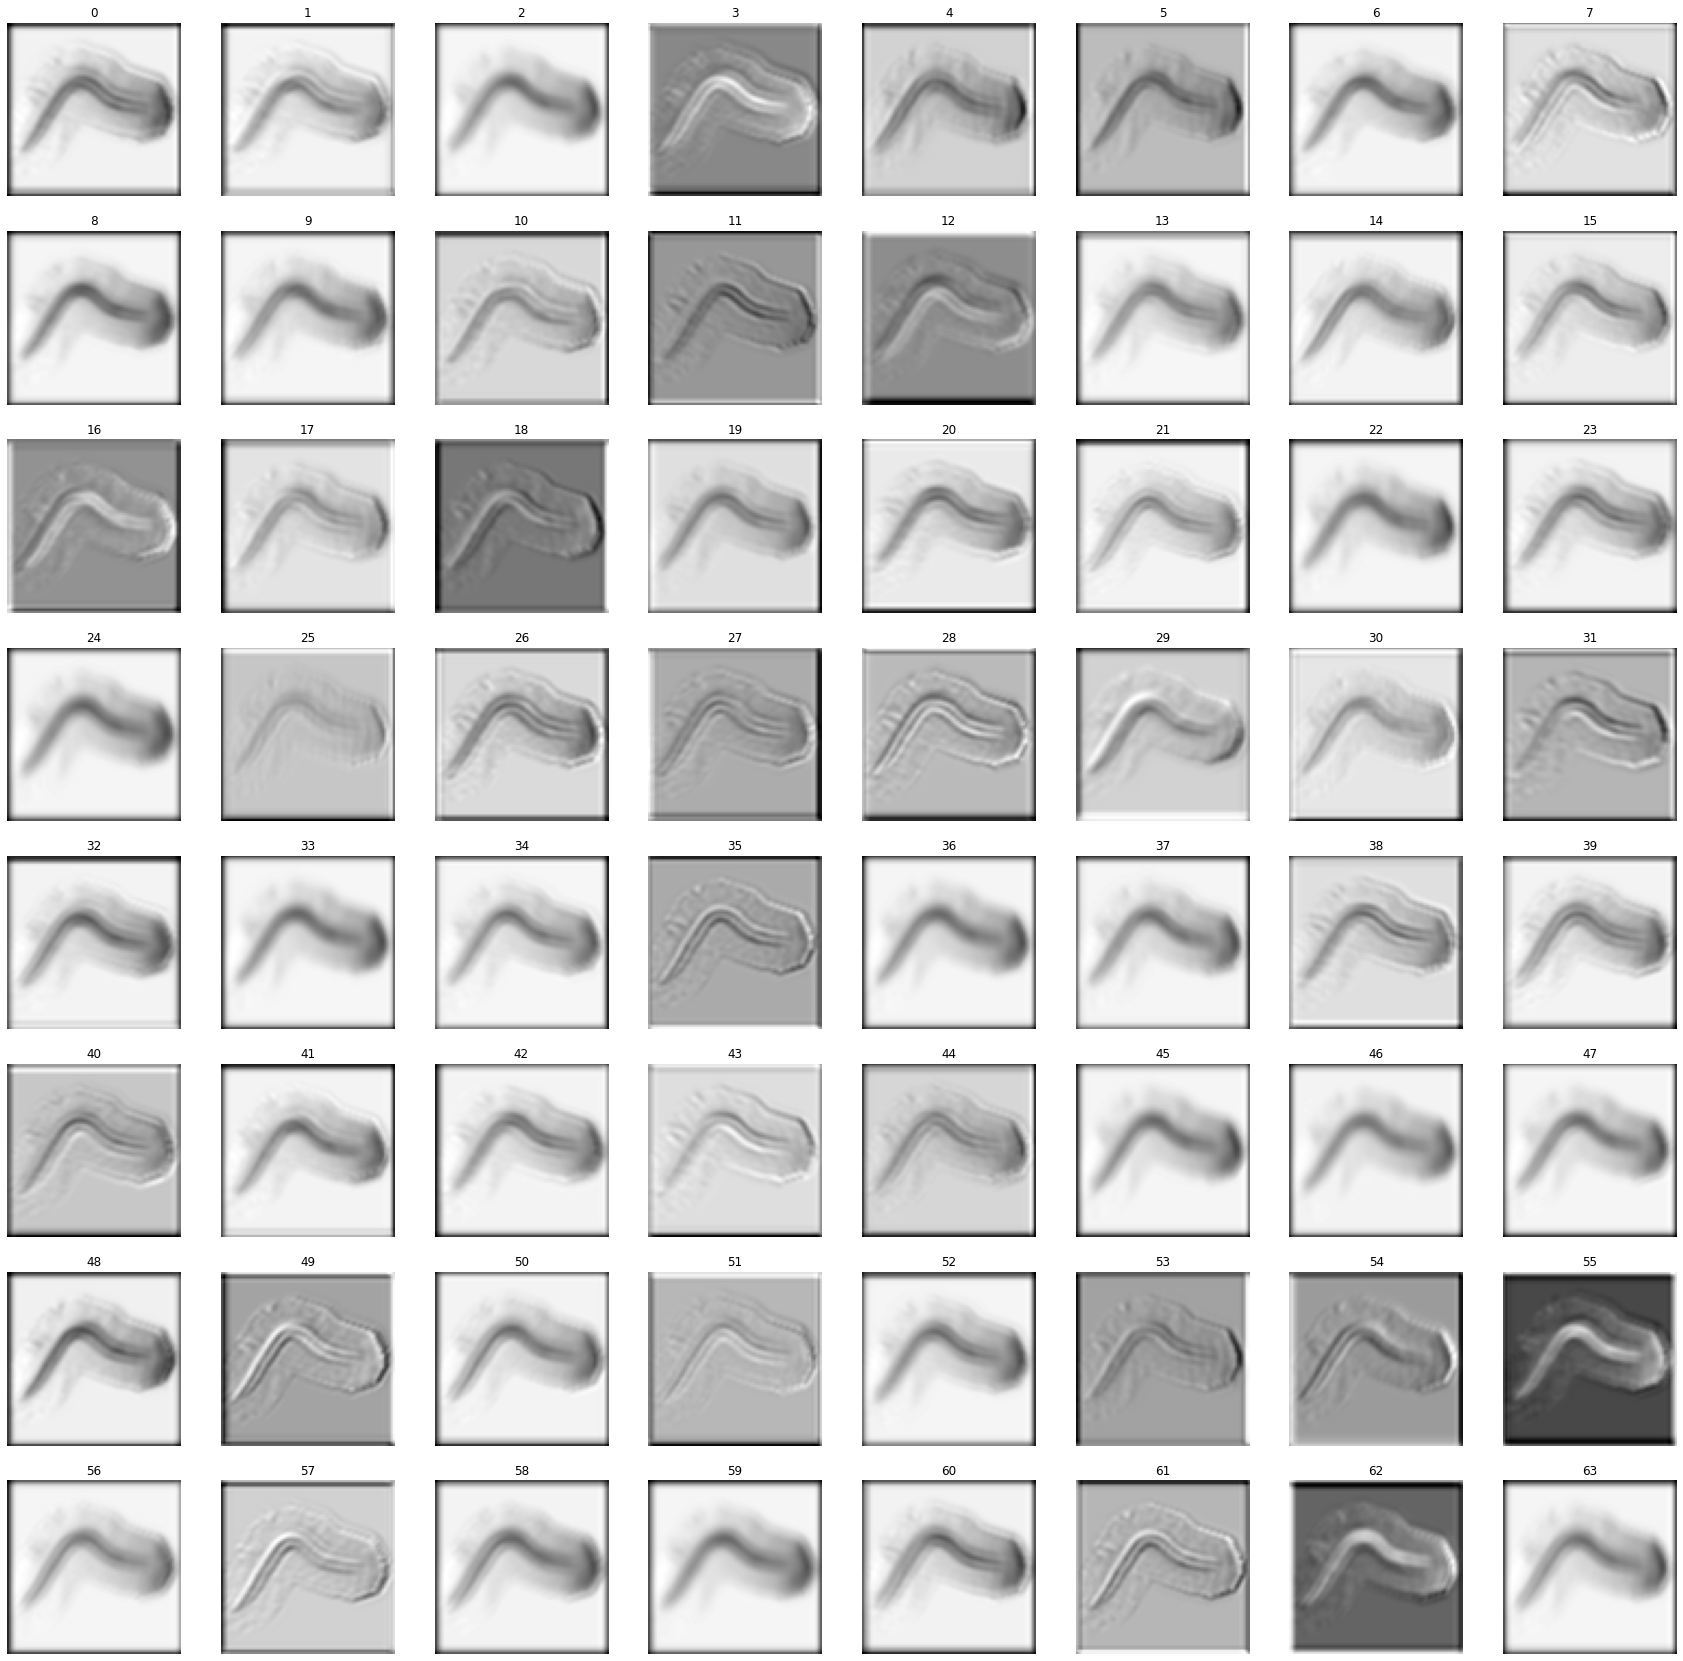

torch.Size([256, 80, 80])


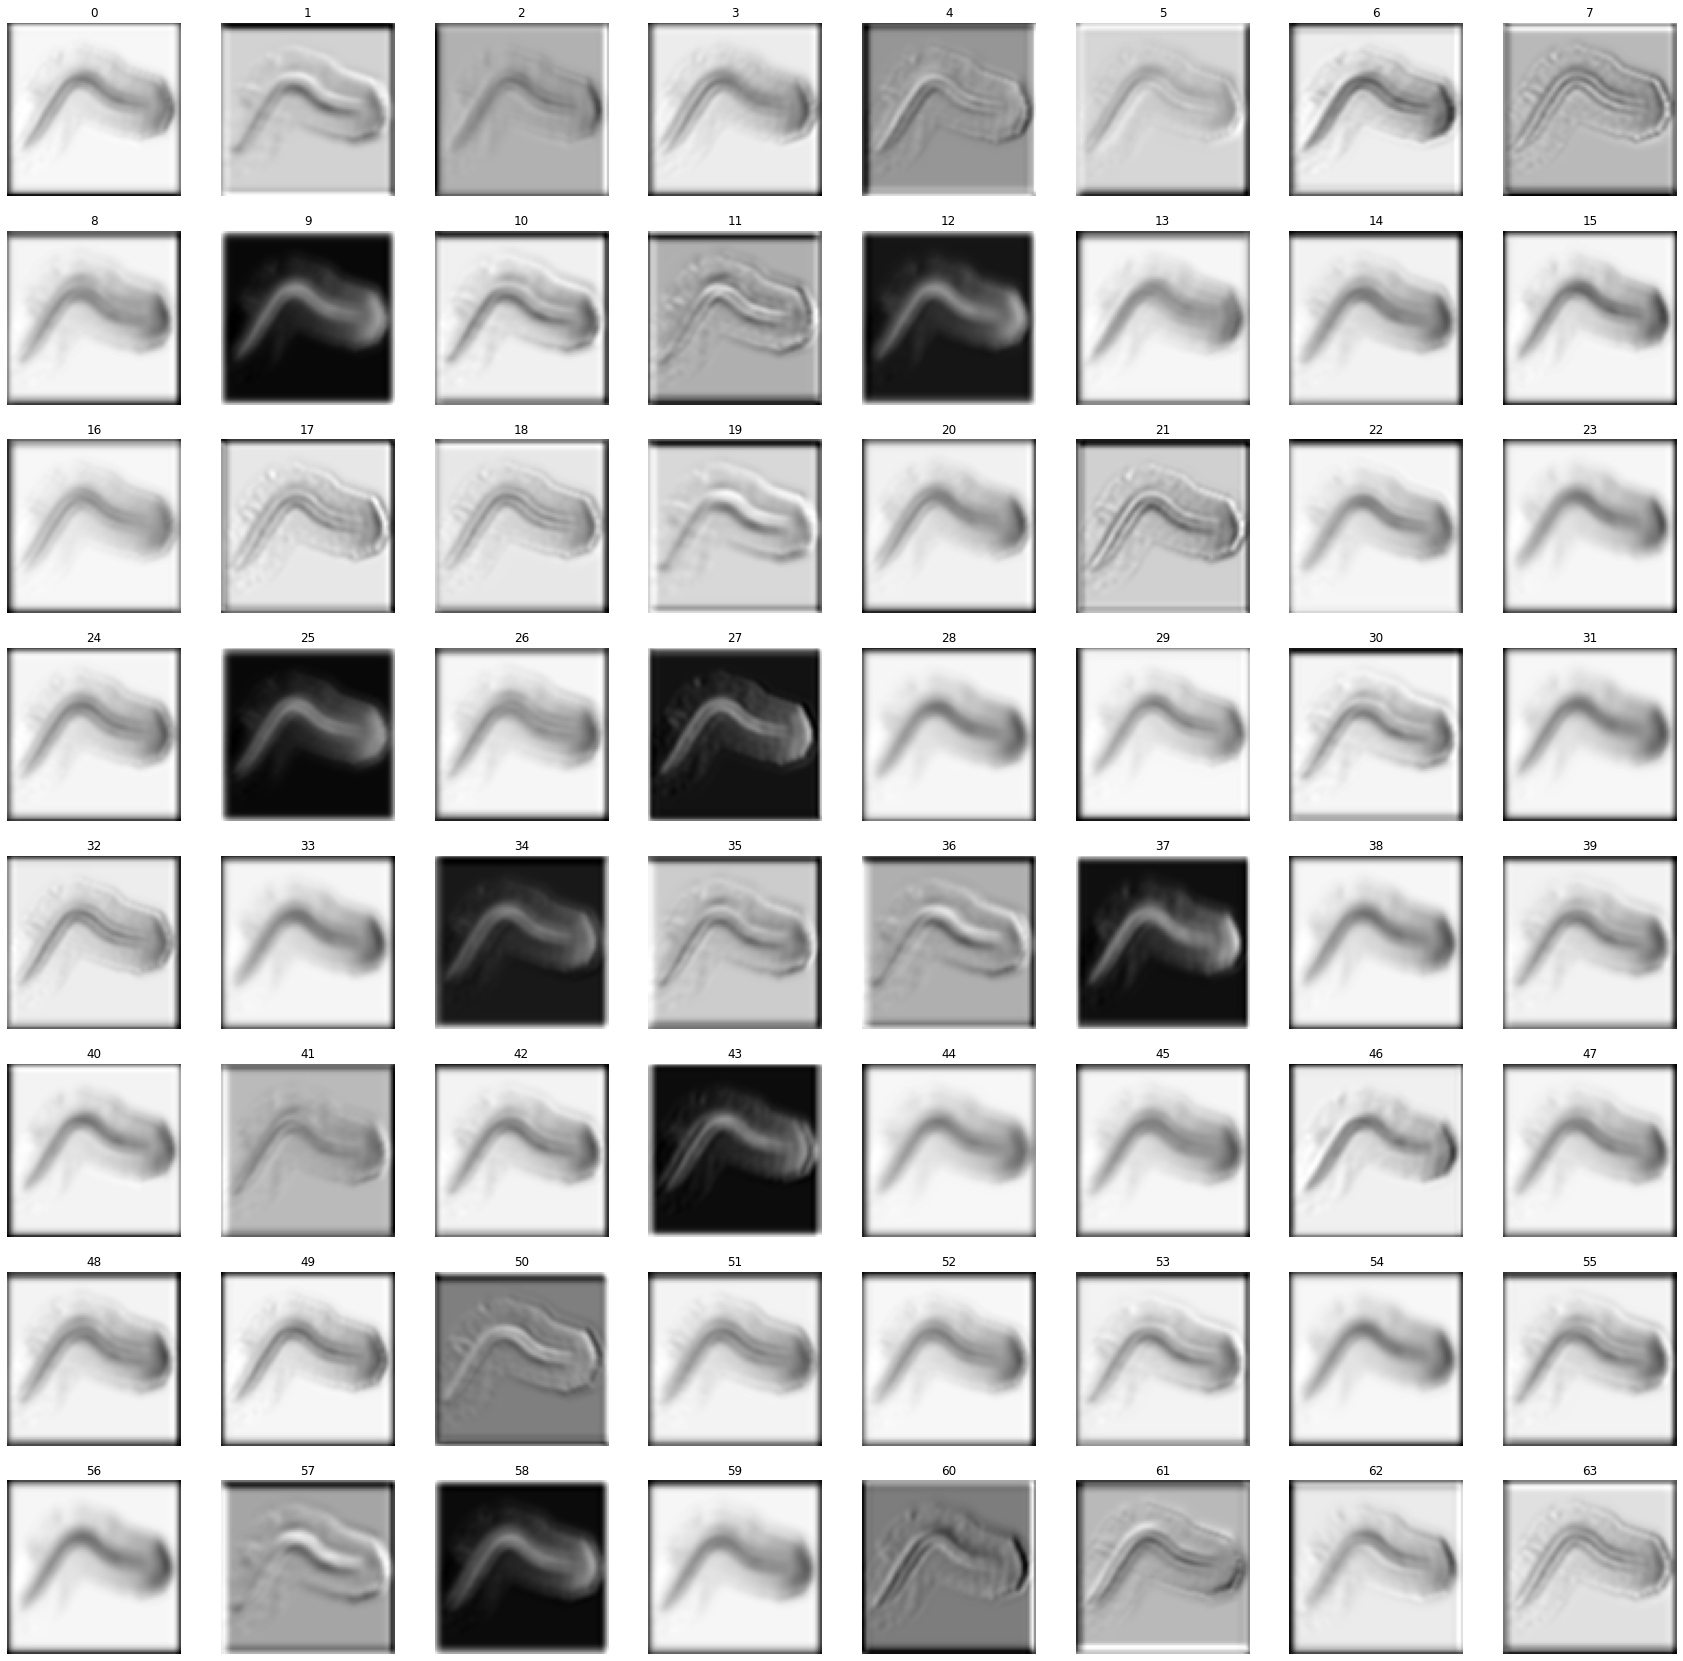

torch.Size([512, 80, 80])


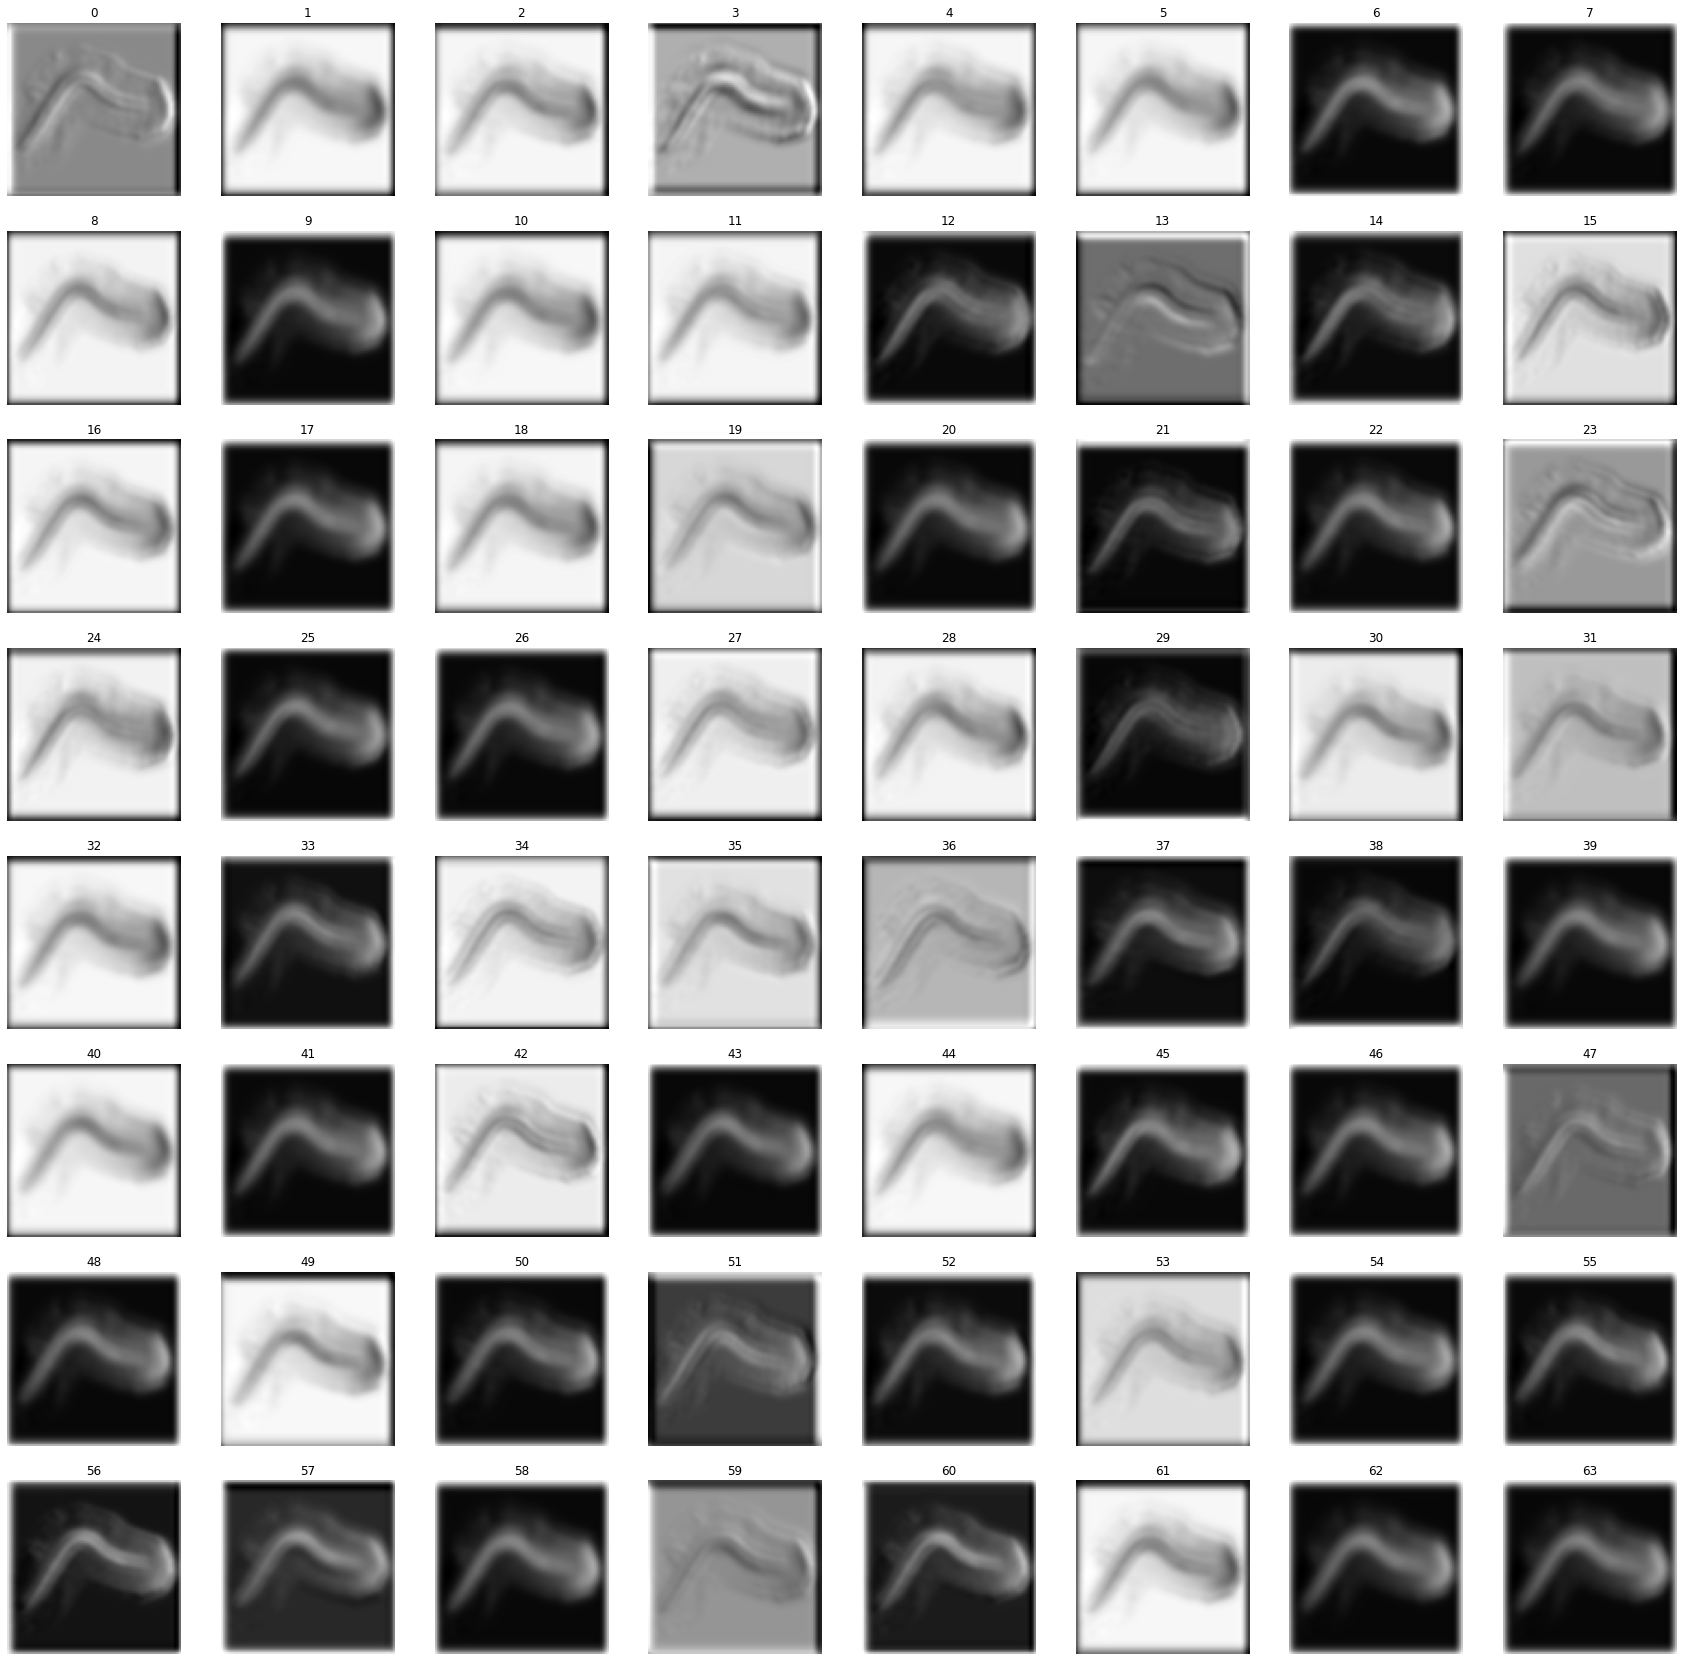

In [ ]:
# visualize features from each layer 
# In the same layer, different filterss focus on different aspects while creating the feature map of an image.
#Some featue maps focus on the background of the image, while the others create an outline of the image. 
# This is due to the corresponding weights of the filters
# As the image progresses through the layers, the details from the images slwoly disappear. 
#They look like noise, but there is a pattern in those feature maps which human eyes cannot detect, but a neural network can
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.title(str(i))
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()